# Visualizing spatial data with Python

In [1]:
%matplotlib inline

import pandas as pd
import geopandas

import matplotlib.pyplot as plt

In [2]:
countries = geopandas.read_file("zip://./data/ne_110m_admin_0_countries.zip")
cities = geopandas.read_file("zip://./data/ne_110m_populated_places.zip")
rivers = geopandas.read_file("zip://./data/ne_50m_rivers_lake_centerlines.zip")

## GeoPandas visualization functionality

#### Basic plot

<AxesSubplot:>

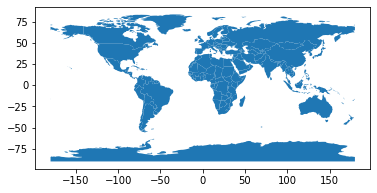

In [3]:
countries.plot()

#### Adjusting the figure size

<AxesSubplot:>

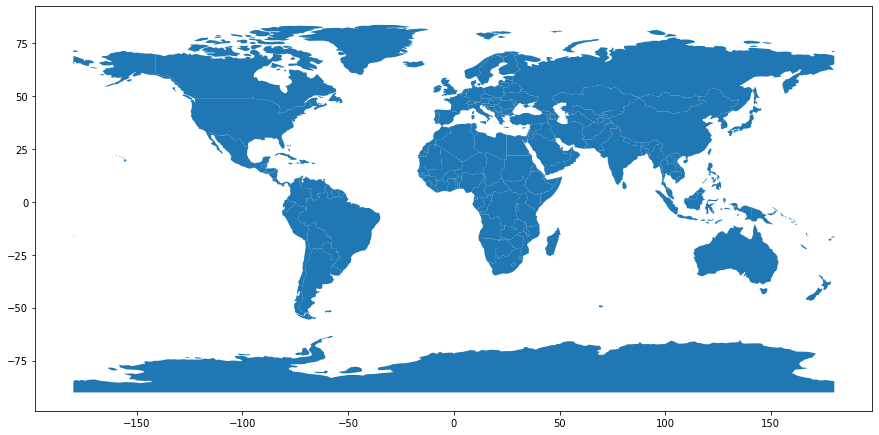

In [4]:
countries.plot(figsize=(15, 15))

#### Removing the box / x and y coordinate labels

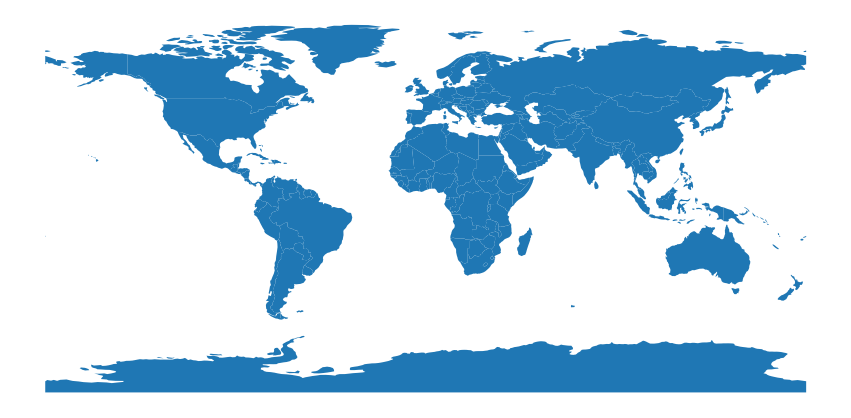

In [5]:
ax = countries.plot(figsize=(15, 15))
ax.set_axis_off()

#### Coloring based on column values

Let's first create a new column with the GDP per capita:

In [6]:
countries = countries[(countries['pop_est'] >0 ) & (countries['name'] != "Antarctica")]

In [8]:
countries['gdp_per_cap'] = countries['gdp_md_est'] / countries['pop_est'] * 100

and now we can use this column to color the polygons:

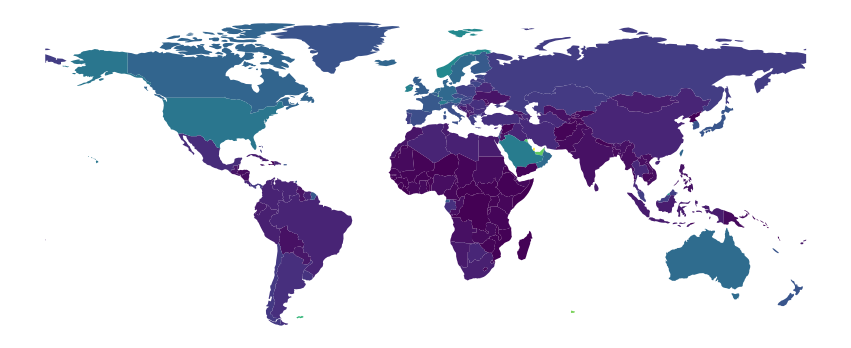

In [9]:
ax = countries.plot(figsize=(15, 15), column='gdp_per_cap')
ax.set_axis_off()

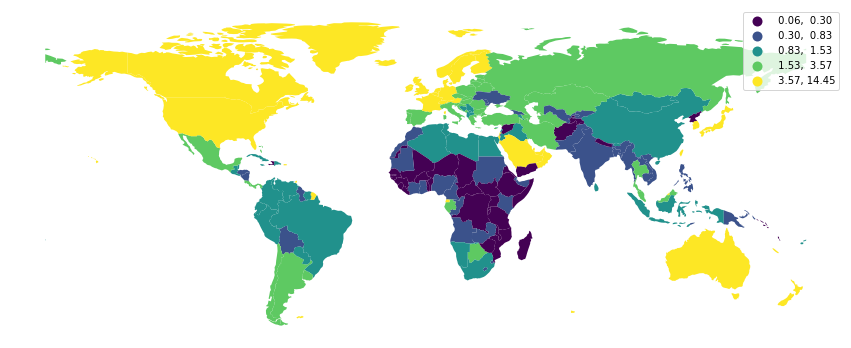

In [10]:
ax = countries.plot(figsize=(15, 15), column='gdp_per_cap', scheme='quantiles', legend=True)
ax.set_axis_off()

#### Combining different dataframes on a single plot

The `.plot` method returns a matplotlib Axes object, which can then be re-used to add additional layers to that plot with the `ax=` keyword:

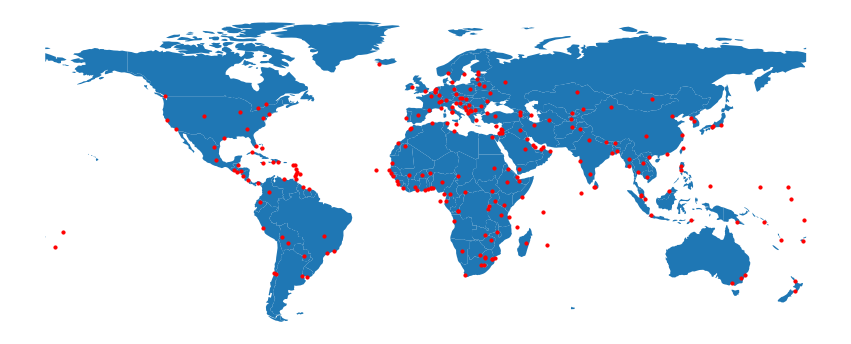

In [11]:
ax = countries.plot(figsize=(15, 15))
cities.plot(ax=ax, color='red', markersize=10)
ax.set_axis_off()

[(-20.0, 60.0), (-40.0, 40.0)]

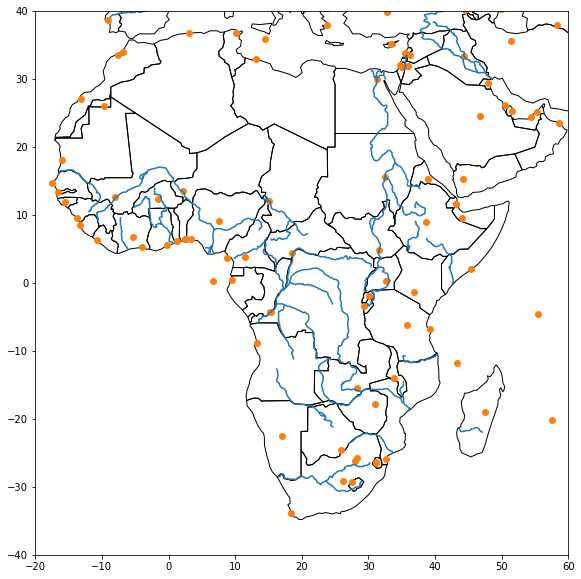

In [12]:
ax = countries.plot(edgecolor='k', facecolor='none', figsize=(15, 10))
rivers.plot(ax=ax)
cities.plot(ax=ax, color='C1')
ax.set(xlim=(-20, 60), ylim=(-40, 40))

## Adding a background map with contextily

The contextily package allow to easily add a web-tile based backgroubd (basemap) to your GeoPandas plots.

Currently, the only requirement is that your data is already in the WebMercator projection (EPSG:3857).

In [13]:
# selecting the cities in Europe
cities_europe = cities[cities.within(countries[countries['continent'] == 'Europe'].unary_union)]

In [14]:
# converting to WebMercator
cities_europe2 = cities_europe.to_crs(epsg=3857)

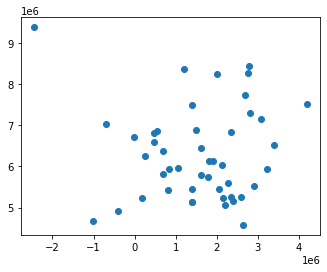

In [15]:
ax = cities_europe2.plot()

In [18]:
import contextily

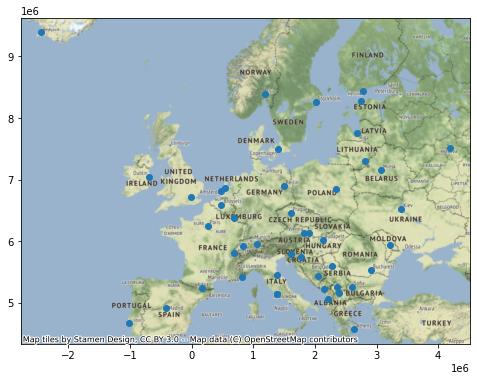

In [19]:
ax = cities_europe2.plot(figsize=(10, 6))
contextily.add_basemap(ax)

<ipython-input-21-a1532d0bea4a>:2: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  contextily.add_basemap(ax, url=contextily.providers.Stamen.TonerLite)


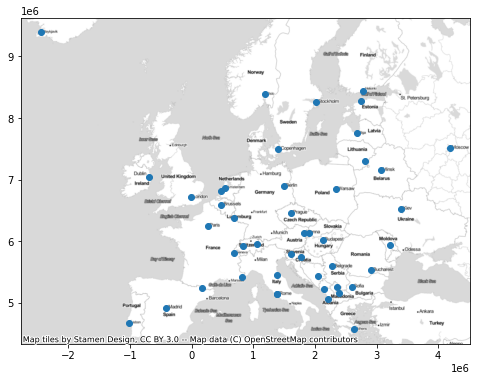

In [21]:
ax = cities_europe2.plot(figsize=(10, 6))
contextily.add_basemap(ax, url=contextily.providers.Stamen.TonerLite)

## Using `geoplot`

The `geoplot` packages provides some additional functionality compared to the basic `.plot()` method on GeoDataFrames:

- High-level plotting API (with more plot types as geopandas)
- Native projection support through cartopy

https://residentmario.github.io/geoplot/index.html

In [24]:
import geoplot
import geoplot.crs as gcrs

ModuleNotFoundError: No module named 'geoplot'

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={
    'projection': gcrs.Orthographic(central_latitude=40.7128, central_longitude=-74.0059)
})
geoplot.choropleth(countries, hue='gdp_per_cap', projection=gcrs.Orthographic(), ax=ax,
                   cmap='magma', linewidth=0.5, edgecolor='white')
ax.set_global()
ax.outline_patch.set_visible(True)
#ax.coastlines()

## Using `cartopy`

Cartopy is the base matplotlib cartographic library, and it is used by `geoplot` under the hood to provide projection-awareness.

http://scitools.org.uk/cartopy/docs/latest/index.html

The following example is taken from the docs: http://geopandas.readthedocs.io/en/latest/gallery/cartopy_convert.html#sphx-glr-gallery-cartopy-convert-py

In [23]:
from cartopy import crs as ccrs

ModuleNotFoundError: No module named 'cartopy'

In [ ]:
# Define the CartoPy CRS object.
crs = ccrs.AlbersEqualArea()

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
countries_ae = countries.to_crs(crs_proj4)

In [ ]:
# Here's what the plot looks like in GeoPandas
countries_ae.plot()

In [ ]:
# Here's what the plot looks like when plotting with cartopy
fig, ax = plt.subplots(subplot_kw={'projection': crs})
ax.add_geometries(countries_ae['geometry'], crs=crs)

In [ ]:
# Here's what the plot looks like when plotting with cartopy and geopandas combined
fig, ax = plt.subplots(subplot_kw={'projection': crs})
countries_ae['geometry'].plot(ax=ax)

## Interactive web-based visualizations

There are nowadays many libraries that target interactive web-based visualizations and that can handle geospatial data. Some packages with an example for each:

- Bokeh: https://bokeh.pydata.org/en/latest/docs/gallery/texas.html
- GeoViews (other interface to Bokeh/matplotlib): http://geo.holoviews.org
- Altair: https://altair-viz.github.io/gallery/choropleth.html
- Plotly: https://plot.ly/python/#maps
- ...

Another popular javascript library for online maps is [Leaflet.js](https://leafletjs.com/), and this has python bindings in the [folium](https://github.com/python-visualization/folium) and [ipyleaflet](https://github.com/jupyter-widgets/ipyleaflet) packages.

An example with ipyleaflet:

In [ ]:
import ipyleaflet

In [ ]:
m = ipyleaflet.Map(center=[48.8566, 2.3429], zoom=6)

layer = ipyleaflet.GeoJSON(data=cities.__geo_interface__)
m.add_layer(layer)
m

In [ ]:
m = ipyleaflet.Map(center=[48.8566, 2.3429], zoom=3)
geo_data = ipyleaflet.GeoData(
    geo_dataframe = countries,
    style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    name = 'Countries')
m.add_layer(geo_data)
m

More: https://ipyleaflet.readthedocs.io/en/latest/api_reference/geodata.html

An example with folium:

In [ ]:
import folium

In [ ]:
m = folium.Map([48.8566, 2.3429], zoom_start=6, tiles="OpenStreetMap")
folium.GeoJson(countries).add_to(m)
folium.GeoJson(cities).add_to(m)
m

In [ ]:
m = folium.Map([0, 0], zoom_start=1)
folium.Choropleth(geo_data=countries, data=countries, columns=['iso_a3', 'gdp_per_cap'],
             key_on='feature.properties.iso_a3', fill_color='BuGn', highlight=True).add_to(m)
m